In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
import logging
# Configure the logging module
logging.basicConfig(level=logging.INFO)  # Set the desired logging level
logging.getLogger("pyvips").setLevel(logging.CRITICAL)

In [3]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as p9
import squidpy as sq
import pandas as pd
import scanpy as sc
import numpy as np
import pyvips
import umap
import json
import os

2024-03-26 15:27:22.351865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 15:27:55.860156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-26 15:27:55.861002: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-26 15:27:55.861019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
from aestetik.utils.utils_morphology import extract_morphology_embeddings
from aestetik.utils.utils_transcriptomics import preprocess_adata
from aestetik.utils.utils_vizualization import get_spot
from aestetik import AESTETIK
AESTETIK.version()

'13.02.2024:18a'

In [5]:
dataset = "simulated_data_10_clusters"
sample = "B"
training_split = "E_test_B_C_D_A"
n_components = 15

In [6]:
out_folder = "out_ablation"
img_path = f"../{dataset}/{out_folder}/data/image/{sample}.tif"

json_path = f"../{dataset}/{out_folder}/data/meta/{sample}.json"
adata_in = f"../{dataset}/{out_folder}/data/h5ad/{sample}.h5ad"
latent_path = f"../{dataset}/{out_folder}/{training_split}/AESTETIK_evaluate/latent/model-{sample}-best_param.csv"
cluster_path = f"../{dataset}/{out_folder}/{training_split}/AESTETIK_evaluate/clusters/model-{sample}-best_param.csv"
img_features_path = f"../{dataset}/{out_folder}/data/image_features/{sample}_inception.npy"

In [7]:
spot_diameter_fullres = json.load(open(json_path))["spot_diameter_fullres"]
dot_size = float(json.load(open(json_path))["dot_size"])
spot_diameter_fullres, dot_size

(1, 0.5)

In [8]:
adata = sc.read(adata_in)
adata = preprocess_adata(adata)

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts


In [9]:
adata.obsm["X_pca_transcriptomics"] = adata.obsm["X_pca"][:,0:n_components]
img_features = np.load(img_features_path)
adata.obsm["X_pca_morphology"] = img_features[:,0:n_components]
model = AESTETIK(adata, 
                 nCluster=adata.obs.ground_truth.unique().size,
                 img_path=img_path,
                 morphology_weight=0,
                 spot_diameter_fullres=spot_diameter_fullres)

INFO:root:The model will be on device: cuda...
INFO:root:The batch_size will be: 2500
INFO:root:Clustering will be performed using bgm and refine_cluster option: True...


In [10]:
model.prepare_input_for_model()

INFO:root:Clustering raw input with bgm...
INFO:root:Computing transcriptomics grid...
100%|██████████| 2500/2500 [00:02<00:00, 880.62it/s]
INFO:root:Computing morphology grid...
100%|██████████| 2500/2500 [00:02<00:00, 876.66it/s]


In [11]:
latent = pd.read_csv(latent_path, index_col=0)
cluster = pd.read_csv(cluster_path)
model.adata.obsm["AESTETIK"] = latent.values
model.adata.obs["AESTETIK_cluster"] = cluster.best_param.values + 1
model.adata.obs["AESTETIK_cluster"] = model.adata.obs["AESTETIK_cluster"].astype(str)

... storing 'X_pca_transcriptomics_cluster' as categorical
... storing 'X_pca_morphology_cluster' as categorical
... storing 'AESTETIK_cluster' as categorical


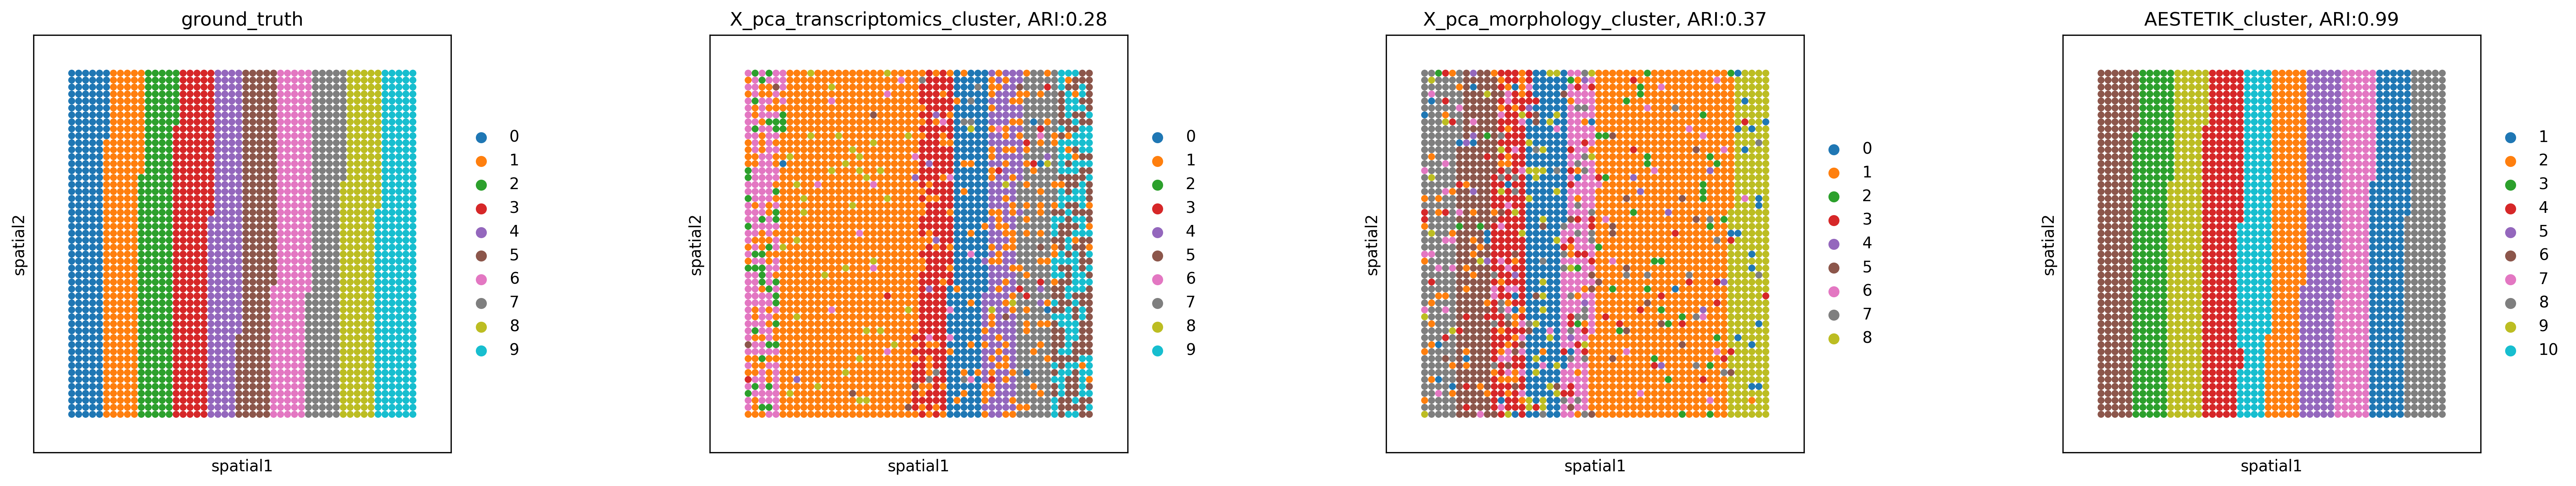

In [16]:
model.vizualize(plot_clusters=True, dot_size=dot_size)

In [12]:
def get_umap2(emb):
    reducer = umap.UMAP()
    umap_emb = reducer.fit_transform(emb)
    return umap_emb

In [13]:
transcriptomics_umap = get_umap2(adata.obsm["X_pca_transcriptomics"])
morphology_umap = get_umap2(adata.obsm["X_pca_morphology"])
aestetik_umap = get_umap2(adata.obsm["AESTETIK"])

In [14]:
df = pd.DataFrame(np.concatenate((transcriptomics_umap, morphology_umap, aestetik_umap), axis=1), 
             columns=["Transcriptomics_1", "Transcriptomics_2",
                      "Morphology_1", "Morphology_2",
                      "AESTETIK_1", "AESTETIK_2",
                     ]
            )
df["ground_truth"] = adata.obs.AESTETIK_cluster.values
df["barcode"] = df.index
df = df.melt(["ground_truth", "barcode"])
df["space"] = df["variable"].apply(lambda x: x.split("_")[0])
df["dim"] = df["variable"].apply(lambda x: f'UMAP_{x.split("_")[1]}')
df.drop({"variable"}, axis=1, inplace=True)
df = df.pivot_table(index=['ground_truth', 'barcode', 'space'], columns='dim', values='value').reset_index()
df

dim  ground_truth  barcode            space     UMAP_1     UMAP_2
0               1     1966         AESTETIK  14.151840  15.965958
1               1     1966       Morphology   8.282729   5.038919
2               1     1966  Transcriptomics   4.262574   6.388272
3               1     1967         AESTETIK  13.945140  16.139402
4               1     1967       Morphology   8.698312   5.854949
...           ...      ...              ...        ...        ...
7495            9      756       Morphology   8.099689   7.763868
7496            9      756  Transcriptomics   2.515256   7.806317
7497            9      757         AESTETIK  -4.562685  11.397982
7498            9      757       Morphology   4.360434   7.334469
7499            9      757  Transcriptomics   1.960574   7.964560

[7500 rows x 5 columns]

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 8 x 12 in image.
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/B_simulated_data_10_clusters_st_m_aestetik_latent.png
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


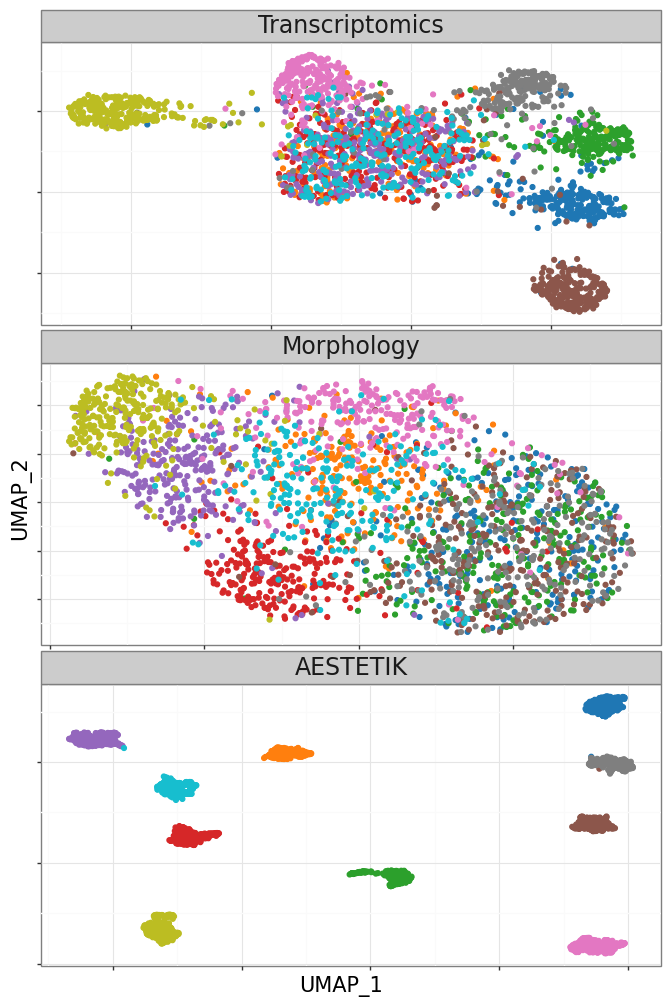

<ggplot: (1448226218054)>

In [24]:
cols = sq.pl._color_utils._get_palette(adata, "AESTETIK_cluster", adata.obs.AESTETIK_cluster.unique())
df.space = pd.Categorical(df.space, ["Transcriptomics", "Morphology", "AESTETIK"])
p = (p9.ggplot(df, p9.aes("UMAP_1", "UMAP_2", color="ground_truth")) 
    + p9.geom_point()
    + p9.facet_wrap("~space", nrow=3, scales="free")
    + p9.theme_bw()
    + p9.theme(subplots_adjust={'wspace': 0.0}, figure_size=(8, 12),
            axis_text_x = p9.element_blank(),
            axis_text_y = p9.element_blank(),
            text=p9.element_text(size=15),
            strip_text=p9.element_text(size=17),
            legend_title=p9.element_text(size=17),
            legend_text=p9.element_text(size=16))
    + p9.scale_color_manual(values=adata.uns["ground_truth_colors"], guide=False)
)
p.save(f"figures/{sample}_{dataset}_st_m_aestetik_latent.png", dpi=300)
p

/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 6 in image.
/cluster/customapps/biomed/grlab/users/knonchev/miniconda3/envs/nonchev/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/B_simulated_data_10_clusters_st_m_aestetik_latent_h.png


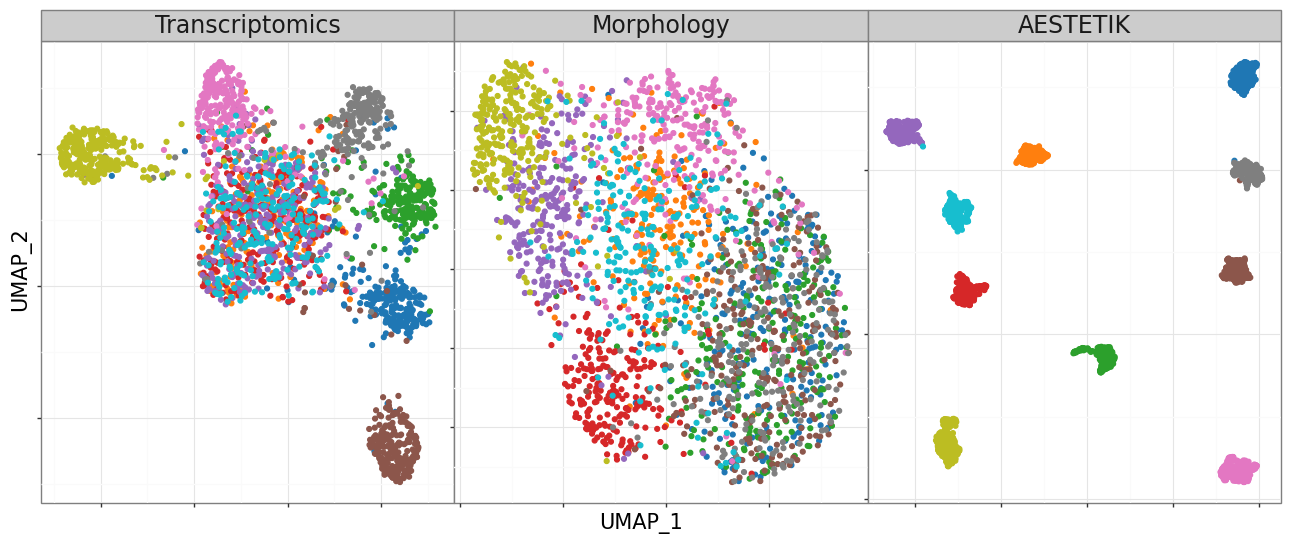

<ggplot: (1448226553233)>

In [23]:
cols = sq.pl._color_utils._get_palette(adata, "AESTETIK_cluster", adata.obs.AESTETIK_cluster.unique())
df.space = pd.Categorical(df.space, ["Transcriptomics", "Morphology", "AESTETIK"])
p = (p9.ggplot(df, p9.aes("UMAP_1", "UMAP_2", color="ground_truth")) 
    + p9.geom_point()
    + p9.facet_wrap("~space", ncol=3, scales="free")
    + p9.theme_bw()
    + p9.theme(subplots_adjust={'wspace': 0.0}, figure_size=(16, 6),
            axis_text_x = p9.element_blank(),
            axis_text_y = p9.element_blank(),
            text=p9.element_text(size=15),
            strip_text=p9.element_text(size=17),
            legend_title=p9.element_text(size=17),
            legend_text=p9.element_text(size=16))
    + p9.scale_color_manual(values=adata.uns["ground_truth_colors"], guide=False)
)
p.save(f"figures/{sample}_{dataset}_st_m_aestetik_latent_h.png", dpi=300)
p